# Training a CNN for DPU compilation
----

## Aim/s

In this notebook we show how to train a simple Convolutional Neural Network (CNN)
on the MNIST handwritten digit dataset for deployment on the DPU. We will cover:

* Loading and pre-processing the imagenet dataset
* Training a CNN with Keras and Tensorflow
* Freezing the trained model
* Quantizing and evaluating the quantized model
* Compiling for DPU using the Vitis AI compiler

## References

* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Mar 8, 2021
    * Initial revision
----


<div class="alert alert-heading alert-info">
This notebook must be run on a proper X86 machine; it has to support
AVX2 and FMA instructions sets.
</div>

To check whether your machine supports AVX2 and FMA instructions sets:
```shell
grep avx2 /proc/cpuinfo
grep fma /proc/cpuinfo
```

Please make sure the following has been done in terminal before you start this notebook:
```shell
conda activate vitis-ai-tensorflow
yes | pip install matplotlib keras==2.2.5
```

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import keras
from keras.layers import Dense, Conv2D, InputLayer, Flatten, MaxPool2D

Using TensorFlow backend.


## 1. Load dataset

The MNIST dataset comes with 60k training and 10k test examples that are
28x28 grayscale images, along with their labels which are just the 
corresponding digits saved as integers. We can use the `keras.datasets`
utility to load the MNIST dataset straight into our Jupyter environment.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print('Training data: {}, {}'.format(x_train.shape, y_train.shape))
print('Test data: {}, {}'.format(x_test.shape, y_test.shape))

11493376/11490434 [==============================] - 3s 0us/step
Training data: (60000, 28, 28), (60000,)
Test data: (10000, 28, 28), (10000,)


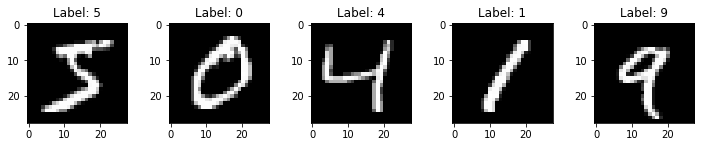

In [3]:
fig, axs = plt.subplots(1, 5, figsize=(10, 10))
plt.tight_layout()

for i in range(5):
    axs[i].imshow(x_train[i], 'gray')
    axs[i].set_title('Label: {}'.format(y_train[i]))

Next we will normalize the training and test images. We also need to add
color channel. All these pre-processing steps are required by Conv2D layers.

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

## 2. Train the model

Create a sequential model by passing a list of layers. Because the MNIST
dataset is not difficult, we can use a very simple network with a single 
convolutional layer.

In [5]:
model = keras.models.Sequential([
    InputLayer(input_shape=(28, 28, 1), name='input_data'),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax', name='output_logits')
])

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               692352    
_________________________________________________________________
output_logits (Dense)        (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________


Configure the model for training: choose desired optimizer, loss function
and metrics to observe over the training period.

In [7]:
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

Now we can train the model.

In [8]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 15s 257us/step - loss: 0.1479 - acc: 0.9561
Epoch 2/5
60000/60000 [==============================] - 14s 228us/step - loss: 0.0482 - acc: 0.9854
Epoch 3/5
60000/60000 [==============================] - 14s 229us/step - loss: 0.0313 - acc: 0.9902
Epoch 4/5
60000/60000 [==============================] - 14s 235us/step - loss: 0.0209 - acc: 0.9936
Epoch 5/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.0143 - acc: 0.9954


We can inspect the training results by plotting the collected data in the
`history` object.

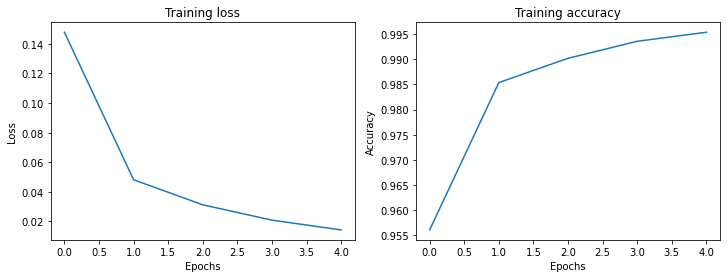

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].set_title('Training loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(history.history['acc'])
axs[1].set_title('Training accuracy')
axs[1].set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

Evaluate the trained model on the test dataset.

In [10]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss: {}".format(loss))
print("Test accuracy: {}".format(accuracy))

10000/10000 [==============================] - 1s 58us/step
Test loss: 0.04735587395107577
Test accuracy: 0.9868


## 3. Save checkpoint
We use the [checkpoint saving method for the Vitis AI flow](https://github.com/Xilinx/Vitis-AI-Tutorials/tree/Keras-Freeze-with-Vitis-AI). We can get the session and graph from the `keras.backend` module
and use those to save a Tensorflow checkpoint compatible with the Vitis AI
workflow. The following cell does the following:

1. Set up Tensorflow saver object
2. Fetch the Tensorflow session using the Keras backend
3. Get the Tensorflow session graph
4. Write out Tensorflow checkpoint and inference graph for use with the freeze_graph script

In [11]:
saver = tf.train.Saver()
tf_session = keras.backend.get_session()
input_graph_def = tf_session.graph.as_graph_def()
save_path = saver.save(tf_session, './checkpoint.ckpt')
tf.train.write_graph(input_graph_def,
                     './', 'mnist_classifier.pb', as_text=False)

'./mnist_classifier.pb'

As well as saving the checkpoint we also need to make a note of the input 
and output nodes of the graph for freezing and quantization. We made our
lives a bit easier by naming the input and output layers, which results
in our input and output nodes being named `input_data` and 
`output_logits/Softmax` respectively. You can check the node names in the 
list defined below.

In [13]:
nodes_names = [node.name for node in 
               tf.get_default_graph().as_graph_def().node]

## 4. Freeze Tensorflow graph
The Vitis AI flow requires a frozen model for quantization. We can obtain a binary
protobuf file of our frozen model by using the Tensorflow `freeze_graph` utility.

In [14]:
!freeze_graph \
    --input_graph mnist_classifier.pb \
    --input_checkpoint checkpoint.ckpt \
    --input_binary true \
    --output_graph frozen.pb \
    --output_node_names output_logits/Softmax

Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0307 16:13:25.973805 139938423334720 deprecation.py:323] From /opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib/python3.6/site-packages/tensorflow_core/python/tools/freeze_graph.py:127: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
2021-03-07 16:13:26.048236: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX FMA
2021-03-07 16:13:26.052257: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3800050000 Hz
2021-03-07 16:13:26.052587: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55835907fc30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-03-07 16:13

## 5. Quantization
We will save some of our training data as calibration data for
`vai_q_tensorflow`, then use that along with the frozen graph to quantize our model.

`vai_q_tensorflow inspect` can be used to confirm available input and output
node names.

In [15]:
!vai_q_tensorflow inspect --input_frozen_graph=frozen.pb

Op types used: 11 Const, 6 Identity, 3 BiasAdd, 2 MatMul, 2 Relu, 1 Conv2D, 1 MaxPool, 1 Pack, 1 Placeholder, 1 Prod, 1 Reshape, 1 Shape, 1 Softmax, 1 StridedSlice

Found 1 possible inputs: (name=input_data, type=float(1), shape=[?,28,28,1]) 
Found 1 possible outputs: (name=output_logits/Softmax, op=Softmax) 


We will save a portion of our training data for quantization.
Recommended number is around 100-1000 for images.

In [16]:
np.savez('./calib_data.npz', data = x_train[:1024])

The quantizer requires an input function to feed batches of calibration data.
In order to replicate the input in the way that the network sees during training, 
you could add normalization and other pre-processing steps here as well. 
Since we saved our calibration data already normalized, we can keep our 
function simple and just use it to pass batches of data to our model.

In the next cell, we will use IPython magic to write a Python file
`input_func.py` in the current working directory. This is required by the
`vai_q_tensorflow` compiler as you can see later.

In [17]:
%%writefile input_func.py
import numpy as np

data = np.load('calib_data.npz')['data']

batch_size=32

def calib_input(iter):

    calib_data = data[iter*batch_size:(iter+1)*batch_size]

    return {'input_data': calib_data}

Writing input_func.py


In [18]:
!vai_q_tensorflow quantize \
    --input_frozen_graph frozen.pb \
    --input_fn input_func.calib_input \
    --output_dir quantized \
    --input_nodes input_data \
    --output_nodes output_logits/Softmax \
    --input_shapes ?,28,28,1 \
    --calib_iter 32

INFO: Checking Float Graph...
INFO: Float Graph Check Done.
INFO: Calibrating for 32 iterations...
100% (32 of 32) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
INFO: Calibration Done.
INFO: Generating Deploy Model...
INFO: Deploy Model Generated.
********************* Quantization Summary *********************      
INFO: Output:       
  quantize_eval_model: quantized/quantize_eval_model.pb       
  deploy_model: quantized/deploy_model.pb


## 6. Evaluate quantized model
The quantizer produces a special model called `quantize_eval_model.pb`, 
which we can use to load up like a regular Tensorfow binary graph and 
evaluate its performance.

Because we already have a graph definition in our session, we need to
reset the default graph so as to not interfere with the graph we are 
about to load from the frozen model.

In [19]:
tf.reset_default_graph()

In order to evaluate a quantized model we have to import `tensorflow.contrib.decent_q`, 
otherwise the model evaluation will error out. We will use standard 
Tensorflow 1, to set up the graph for evaluation.

In the next cell, we will read in a frozen binary graph and add the 
accuracy metric.

In [20]:
import tensorflow.contrib.decent_q

with tf.gfile.GFile('quantized/quantize_eval_model.pb', "rb") as f:
    graph = tf.GraphDef()
    graph.ParseFromString(f.read())

tf.import_graph_def(graph,name = '')

input_data = tf.get_default_graph().get_tensor_by_name('input_data'+':0')
labels = tf.placeholder(tf.int64, shape=[None,])
logits = tf.get_default_graph().get_tensor_by_name(
    'output_logits/Softmax'+':0')

nn_output = tf.argmax(logits, 1)
correct_prediction = tf.equal(nn_output, labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Run a Tensorflow session to evaluate the test accuracy of the quantized model.
If the accuracy at this stage is acceptable, we can proceed to compilation 
and deployment on DPU.

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.initializers.local_variables())
    
    acc = accuracy.eval(feed_dict={input_data: x_test, labels: y_test})
    print("Average accuracy on test set: {}".format(acc))

Average accuracy on test set: 0.986299991607666


## 7. Compilation
Now that we are satisfied with our quantized model accuracy, we can compile it and move onto the target.

This example targets the ZCU111 (or ZCU102 which uses the same DPU 
configuration as ZCU102). You can target a different architecture by
specifying its configuration json file with the `--arch` flag.

In [22]:
!vai_c_tensorflow \
    --frozen_pb quantized/quantize_eval_model.pb \
    --arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/Ultra96/arch.json \
    --output_dir . \
    --net_name mnist_classifier

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(inputs_shape=None, layout='NHWC', model_files=['quantized/quantize_eval_model.pb'], model_type='tensorflow', out_filename='./mnist_classifier_org.xmodel', proto=None)
[INFO] tensorflow model: quantized/quantize_eval_model.pb
[INFO] generate xmodel     :100%|█| 20/20 [00:00<00:00, 788.99it/s]             
[INFO] generate xmodel: /workspace/xilinx-vitis-ai/1600_host/mnist-96/mnist_classifier_org.xmodel
[UNILOG][INFO] The compiler log will be dumped at "/tmp/vitis-ai-user/log/xcompiler-20210307-164129-338"
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_CUSTOMIZED
[UNILOG][INFO] Graph name: quantize_eval_model, with op num: 28
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INF

Note that some node names are different now, take a note of these, as they are required by the DNNDK API on the target. 

* Input node: `conv2d_1_convolution`
* Output node: `output_logits_MatMul`
* Kernel name: `mnist_classifier_0`

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----